### 0.1 Check python version

In [1]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

### 0.2 Check that notebook server has access to all required resources, and that notebook has not moved

In [2]:
import os
nb_dirname = os.path.abspath("")
assignment_name = os.path.basename(nb_dirname)

import sys
sys.path.append("..")

### 0.3 Imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import random
import torch.utils

from itertools import chain
from PIL import Image

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import torch.nn.functional as F
from typing import Callable, Union
from datetime import datetime
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import pandas as pd

# For splitting the data
from sklearn.model_selection import train_test_split
import shutil

### 0.4 Check for CUDA

In [4]:
print(f"CUDA is available:{torch.cuda.is_available()}") # test if gpu env is working
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available:True


### 1.1 Unzipping data

Only run this cell if you have not already unzipped and processed the data into correct folders

In [5]:
data_path = Path.cwd()
zip_file = data_path / "EC_dataset.zip"

# Check so that the .zip file excists
if not zip_file.exists():
    raise FileNotFoundError(
        "Download and place `{}` in the current directory (`{}`)".format(
            zip_file.name, data_path
        )
    )

# Folders from pre_existing_items will be deleted and we will start over from zip file: EC_dataset.zip
pre_existing_items = map(
    lambda x: data_path / Path(x),
    [
        "train",
        "validation",
        "test",
    ],
)

for item in pre_existing_items:
    if item.exists():
        # We need to use different functions for files and directories.
        if item.is_dir():
            shutil.rmtree(item)
        elif item.is_file():
            item.unlink()
        else:
            print("Unknown item: {}, remove manually".format(item))

# Unpacking the EC_dataset.zip into test and train
shutil.unpack_archive(zip_file, data_path)


### 1.2 Examining datasets

In [6]:
# Define the paths to the test and validation directories
train_dir = Path('train')
test_dir = Path('test')

# Function to count image files in a given directory and its subdirectories
def count_images_in_folder(directory):
    return len(list(directory.glob('**/*.*')))  # Adjust pattern to target specific file types (e.g., '*.jpg')

# Function to count images in each class subfolder
def count_images_in_classes(base_directory):
    class_counts = {}
    for class_dir in base_directory.iterdir():
        if class_dir.is_dir():
            class_counts[class_dir.name] = count_images_in_folder(class_dir)
    return class_counts

# Count images in 'train' and 'test' folders
train_image_count = count_images_in_folder(train_dir)
test_image_count = count_images_in_folder(test_dir)

# Count images in each class for train and test sets
train_class_counts = count_images_in_classes(train_dir)
test_class_counts = count_images_in_classes(test_dir)

# Calculate total images
total_images = train_image_count + test_image_count

# Calculate percentages
train_percentage = (train_image_count / total_images) * 100 if total_images > 0 else 0
test_percentage = (test_image_count / total_images) * 100 if total_images > 0 else 0

# Print results for train set
print(f"Number of images in 'train': {train_image_count} ({train_percentage:.2f}%)")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / train_image_count) * 100:.2f}%)" 
                                 for class_name, count in train_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

W_training = torch.tensor([count for class_name, count in train_class_counts.items()], dtype=torch.float32).to(device)

# Print results for test set
print(f"Number of images in 'test': {test_image_count} ({test_percentage:.2f}%)")
test_class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / test_image_count) * 100:.2f}%)" 
                                      for class_name, count in test_class_counts.items()])
print(f"  Class counts: {test_class_counts_row}")

# Print total images
print(f"Total images: {total_images}")

Number of images in 'train': 28709 (80.00%)
  Class counts: happy: 7215 (25.13%) | neutral: 4965 (17.29%) | angry: 3995 (13.92%) | surprised: 3171 (11.05%) | fearful: 4097 (14.27%) | disgusted: 436 (1.52%) | sad: 4830 (16.82%)
Number of images in 'test': 7178 (20.00%)
  Class counts: happy: 1774 (24.71%) | neutral: 1233 (17.18%) | angry: 958 (13.35%) | surprised: 831 (11.58%) | fearful: 1024 (14.27%) | disgusted: 111 (1.55%) | sad: 1247 (17.37%)
Total images: 35887


We are missing a validation dataset, we will thus create one given from the test set. As we can see above, a class inbalance occurs. We do however have the same class inbalance for the test and train dataset, we want to keep this class inbalance for the validation set aswell

### 1.3 Creating Validation dataset by splitting test set

In [7]:
# Define paths
test_dir = Path('test')
validation_dir = Path('validation')
new_test_dir = Path('new_test')  # Temporary directory for the new test set

# Create the validation and new_test directories if they don't exist
validation_dir.mkdir(exist_ok=True)
new_test_dir.mkdir(exist_ok=True)

# Function to split a class folder into validation and new test set
def split_class_folder(class_name, source_folder, target_folder, validation_ratio=0.5):
    class_folder = source_folder / class_name
    images = list(class_folder.glob('*.*'))  # Adjust pattern to target specific file types (e.g., '*.jpg')
    random.shuffle(images)  # Shuffle the images to randomize selection

    # Calculate split index
    split_index = int(len(images) * validation_ratio)

    # Create target folders
    (target_folder / class_name).mkdir(parents=True, exist_ok=True)
    (validation_dir / class_name).mkdir(parents=True, exist_ok=True)

    # Move images to new test and validation directories
    for img in images[:split_index]:  # First half goes to validation
        shutil.move(str(img), str(validation_dir / class_name / img.name))

    for img in images[split_index:]:  # Second half goes to new test
        shutil.move(str(img), str(target_folder / class_name / img.name))

# Split each class folder in the test set
for class_folder in test_dir.iterdir():
    if class_folder.is_dir():
        split_class_folder(class_folder.name, test_dir, new_test_dir)

# Delete the old test directory
shutil.rmtree(test_dir)

# Rename new_test to test
new_test_dir.rename(test_dir)

# Count images in 'train', 'test', and 'validation' folders
train_image_count = count_images_in_folder(train_dir)
test_image_count = count_images_in_folder(test_dir)
validation_image_count = count_images_in_folder(validation_dir)  # Count images in validation folder

# Count images in each class for train, test, and validation sets
train_class_counts = count_images_in_classes(train_dir)
test_class_counts = count_images_in_classes(test_dir)
validation_class_counts = count_images_in_classes(validation_dir)  # Count classes in validation

# Calculate total images
total_images = train_image_count + test_image_count + validation_image_count  # Include validation count

# Calculate percentages
train_percentage = (train_image_count / total_images) * 100 if total_images > 0 else 0
test_percentage = (test_image_count / total_images) * 100 if total_images > 0 else 0
validation_percentage = (validation_image_count / total_images) * 100 if total_images > 0 else 0  # Calculate validation percentage

# Print results for train set
print(f"Number of images in 'train': {train_image_count} ({train_percentage:.2f}%)")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / train_image_count) * 100:.2f}%)" 
                                 for class_name, count in train_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

# Print results for test set
print(f"Number of images in 'test': {test_image_count} ({test_percentage:.2f}%)")
test_class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / test_image_count) * 100:.2f}%)" 
                                      for class_name, count in test_class_counts.items()])
print(f"  Class counts: {test_class_counts_row}")

# Print results for validation set
print(f"Number of images in 'validation': {validation_image_count} ({validation_percentage:.2f}%)")
validation_class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / validation_image_count) * 100:.2f}%)" 
                                            for class_name, count in validation_class_counts.items()])
print(f"  Class counts: {validation_class_counts_row}")


Number of images in 'train': 28709 (80.00%)
  Class counts: happy: 7215 (25.13%) | neutral: 4965 (17.29%) | angry: 3995 (13.92%) | surprised: 3171 (11.05%) | fearful: 4097 (14.27%) | disgusted: 436 (1.52%) | sad: 4830 (16.82%)
Number of images in 'test': 3591 (10.01%)
  Class counts: happy: 887 (24.70%) | neutral: 617 (17.18%) | angry: 479 (13.34%) | surprised: 416 (11.58%) | fearful: 512 (14.26%) | disgusted: 56 (1.56%) | sad: 624 (17.38%)
Number of images in 'validation': 3587 (10.00%)
  Class counts: happy: 887 (24.73%) | neutral: 616 (17.17%) | angry: 479 (13.35%) | surprised: 415 (11.57%) | fearful: 512 (14.27%) | disgusted: 55 (1.53%) | sad: 623 (17.37%)


### 1.4 Add class names to images in format: \<class_name\>.\<im_num\>.png

In [8]:
def rename_images_with_class_name(root_dir):
    """Rename images in subdirectories to include the class name.

    Args:
        root_dir (Path/str): The root directory containing 'train', 'validation', and 'test' folders.
    """
    root_dir = Path(root_dir)
    if not (root_dir.exists() and root_dir.is_dir()):
        raise ValueError(f"Data root '{root_dir}' is invalid")

    # Iterate through train, validation, and test directories
    for split in ['train', 'validation', 'test']:
        split_dir = root_dir / split
        if not split_dir.exists():
            continue

        # Iterate through each emotion subdirectory
        for emotion_dir in split_dir.iterdir():
            if emotion_dir.is_dir():
                
                # Iterate through images in the emotion directory
                for img_path in emotion_dir.glob("*.png"):  
                    
                    # Get the original image name without extension
                    original_name = img_path.stem
                    
                    # Create the new image name with the format: folder_name.original_name.png
                    new_name = f"{emotion_dir.name}.{original_name}.png"
                    new_path = emotion_dir / new_name
                    
                    # Rename the image
                    img_path.rename(new_path)

# Usage
rename_images_with_class_name(Path(os.path.abspath("")))  # Replace with your actual data root

### 1.5 Create dataset abstraction class

In [9]:
class EmotionsData(Dataset):
    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './emotion_data'
            transform (Compose): A composition of image transforms.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform

        # Define emotion labels and their corresponding indices
        self.emotion_labels = {
            "angry": 0,
            "disgusted": 1,
            "fearful": 2,
            "happy": 3,
            "neutral": 4,
            "sad": 5,
            "surprised": 6
        }


        # Collect samples and store pairs of (filepath, label) in a list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels for emotions

        Helper method for the constructor.
        """
        # Create an empty list to store all paths and labels
        all_paths_and_labels = []
        
        # Iterate over each emotion and its corresponding label
        for emotion, label in self.emotion_labels.items():
            
            # Collect paths for the current emotion
            emotion_paths = self._collect_imgs_sub_dir(self.root / emotion)
            
            # Map each path to the corresponding emotion label
            emotion_paths_and_labels = map(lambda path: (path, label), emotion_paths)
            
            # Add to the list of all paths and labels
            all_paths_and_labels.extend(emotion_paths_and_labels)
        
        # Sort the paths for consistency (by filename stem)
        return sorted(all_paths_and_labels, key=lambda x: x[0].stem)
            

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.png")

    
    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.

        Args:
            id_ (str): Image id, e.g. `emotion.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

### 1.6 Normalize and create dataset objects

In [10]:
# transform the data to tensor
transform = Compose([ToTensor()])

# create initial object for the training dataset
train_path = "./train"
train_dataset = EmotionsData(train_path, transform = transform)

validation_path = "./validation"
validation_dataset = EmotionsData(validation_path, transform = transform)

test_path = "./test"
test_dataset = EmotionsData(test_path, transform = transform)

In [11]:
def calculate_mean_std(dataset):
    """
    Returns:
    - mean: A tensor representing the mean of the dataset.
    - std: A tensor representing the standard deviation of the dataset.
    """
    
    # Stack all images into a single tensor
    all_images = torch.stack([img_tensor for img_tensor, _ in dataset])

    # Calculate mean and std
    mean = all_images.mean(dim=[0, 2, 3])  # Average over batch, height, and width
    std = all_images.std(dim=[0, 2, 3])    # Standard deviation over batch, height, and width

    return mean, std

#print(calculate_mean_std(train_dataset))
#print(calculate_mean_std(validation_dataset))
#print(calculate_mean_std(test_dataset))


In [12]:
# Calculating the mean and std of the training dataset
train_mean, train_std = calculate_mean_std(train_dataset)

# New transform including normalization
transformation_w_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean,  
                         std=train_std)   
])

# Crearting normalized datasets
n_train_dataset = EmotionsData(train_path, transform = transformation_w_norm)

n_validation_dataset = EmotionsData(validation_path, transform = transformation_w_norm)


n_test_dataset = EmotionsData(test_path, transform = transformation_w_norm)

# Format: train_dataset[element][ 0 = img_tensor, 1 = label], label is decided from self.emotion_labels in the EmotionsData class
#print(train_dataset[0][0])


# Length of datasets
#print(len(train_dataset))
#print(len(validation_dataset))
#print(len(test_dataset))

In [13]:
print(train_dataset[100][0])
print(train_dataset[100][0].size())

tensor([[[0.2353, 0.2392, 0.2392,  ..., 0.5765, 0.5922, 0.4745],
         [0.2275, 0.2549, 0.2431,  ..., 0.5804, 0.6039, 0.5961],
         [0.2392, 0.2667, 0.3020,  ..., 0.5255, 0.6078, 0.6392],
         ...,
         [0.6471, 0.5412, 0.4824,  ..., 0.4314, 0.4941, 0.4314],
         [0.5922, 0.4941, 0.4863,  ..., 0.4275, 0.5098, 0.4627],
         [0.5608, 0.4510, 0.4706,  ..., 0.4667, 0.4392, 0.5529]]])
torch.Size([1, 48, 48])


### 1.7 Display image from each class

TRAIN DATASET IMAGES


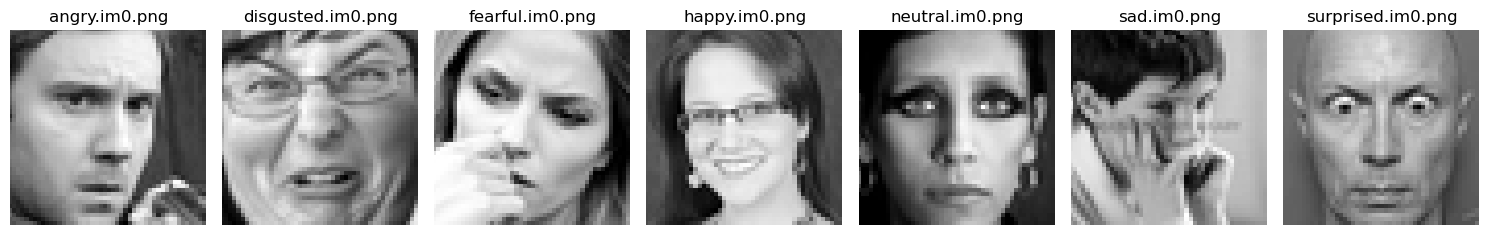

VALIDATION DATASET IMAGES


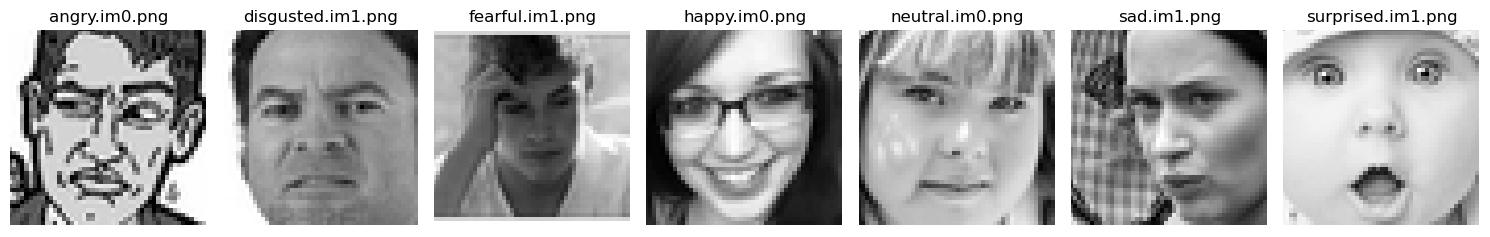

TEST DATASET IMAGES


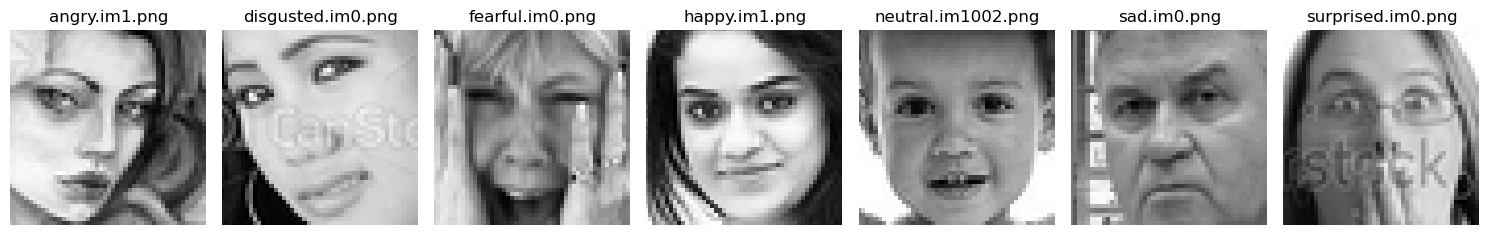

In [14]:
def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels, width, height)
    """
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor`, "
            "use the `ToTensor` transformation to convert the images to tensors."
        )

    # Check if the tensor is grayscale
    if image_tensor.size(0) == 1:
        # Grayscale image (shape: [1, height, width])
        image_data = image_tensor.squeeze(0).numpy()  # Remove the channel dimension
        axis.imshow(image_data, cmap='gray')  # Display as grayscale
    else:
        raise ValueError(f"Unsupported image shape: {image_tensor.size()}")

    # Set limits for the axes
    height, width = image_data.shape[:2]
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)  # Switch the y-limits to start from the top
    axis.axis('off')  # Turn off axis labels for a cleaner look

def show_sample_images(dataset):
    """Display one image from each emotion class.

    Args:
        dataset: Instance of your EmotionsDataset class.
    """
    fig, axes = plt.subplots(1, len(dataset.emotion_labels), figsize=(15, 5))

    for i, (emotion, label) in enumerate(dataset.emotion_labels.items()):
        # Find the first image for each emotion class in the dataset samples
        for img_path, img_label in dataset._samples:
            if img_label == label:
                # Load the image using the same logic as in your __getitem__ method
                img = Image.open(img_path)

                # Apply transformations if any
                if dataset.transform is not None:
                    img = dataset.transform(img)
                
                # Display the image on the respective axis
                display_image(axes[i], img)

                axes[i].set_title(img_path.name)
                break

    plt.tight_layout()
    plt.show()

print("TRAIN DATASET IMAGES")
show_sample_images(n_train_dataset)

print("VALIDATION DATASET IMAGES")
show_sample_images(n_validation_dataset)

print("TEST DATASET IMAGES")
show_sample_images(n_test_dataset)

 Comment / question:  Normalization doesn't seem to have any affect, quality of dataset might not be great, if one looks att the example images above !!!!!!!!!

### 1.8 Dataloaders ###

In [15]:
# Parameters to choose for training performance

batch_size = 512 # choose high for fast training, in my experience
workers = 8 # Works for chosen gpu

train_Dataloader = DataLoader(n_train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
validation_Dataloader = DataLoader(n_validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
test_Dataloader = DataLoader(n_test_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

### 2.0 Creating the model

In [15]:
class EmotionDetectionModel(nn.Module):
    
    def __init__(self, img_size):
        super(EmotionDetectionModel, self).__init__()

        self._num_classes = 7
        self._img_channels = 1
        self.dropout_factor1 = 0.2
        self.dropout_factor2 = 0.4

        # input to BatchNorm2d is the amount of filters
        
        # First convolution block -----
        self.conv1 = nn.Conv2d(in_channels=self._img_channels, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(self.dropout_factor1)
        
        
        # Second convolution block -----
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(self.dropout_factor1)
        
        
        # Third convolution block -----
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(self.dropout_factor1)


        # Fully connected layers
        
        # Calculate the output size of the feature maps after the convolutional layers
        self.flatten_size = self._calculate_conv_output_size(img_size)

        # Fully connected layer 1
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(self.dropout_factor2)

        # Fully connected layer 2
        self.fc2 = nn.Linear(128, self._num_classes)

    
    def _calculate_conv_output_size(self, img_size):
        # Helper method to compute the spatial dimensions after the convolution and pooling layers
        size = img_size // 8  # Since 3 pooling layers, we reduce the size by a factor of 8
        return size * size * 256  # 256 filters at the final conv layer

    
    def save_model(self, train_losses, train_accs, val_losses, val_accs):
        # Get the current date and time
        date_and_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

        # Save the model state and training history
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "train_losses": train_losses,
                "train_accs": train_accs,
                "val_losses": val_losses,
                "val_accs": val_accs,
            },
            f"./EmotionDetectionModel-{date_and_time}.ckpt",  # Use f-string for formatting
        )
        
    
    def forward(self, x):
        
        # First convolution block -----
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second convolution block -----
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third convolution block -----
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

### 2.1 Second iteration of model

In [16]:
batch_size = 32 # choose high for fast training, in my experience

#train_Dataloader = DataLoader(n_train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
#validation_Dataloader = DataLoader(n_validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
#test_Dataloader = DataLoader(n_test_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

class EmotionDetectionModel2(nn.Module):
    
    def __init__(self, img_size):
        super(EmotionDetectionModel2, self).__init__()

        self._num_classes = 7
        self._img_channels = 1
        self.dropout_factor1 = 0.2
        self.dropout_factor2 = 0.4

        # input to BatchNorm2d is the amount of filters
        
        # First convolution block -----
        self.conv1 = nn.Conv2d(in_channels=self._img_channels, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.4)
        
        
        # Second convolution block -----
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.4)
        
        
        # Third convolution block -----
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.5)


        # Fully connected layers
        
        # Calculate the output size of the feature maps after the convolutional layers
        self.flatten_size = self._calculate_conv_output_size(img_size)

        # Fully connected layer 1
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.6)

        # Fully connected layer 2
        self.fc2 = nn.Linear(128, self._num_classes)

    
    def _calculate_conv_output_size(self, img_size):
        # Helper method to compute the spatial dimensions after the convolution and pooling layers
        size = img_size // 8  # Since 3 pooling layers, we reduce the size by a factor of 8
        return size * size * 256  # 256 filters at the final conv layer

    
    def save_model(self, train_losses, train_accs, val_losses, val_accs):
        # Get the current date and time
        date_and_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

        # Save the model state and training history
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "train_losses": train_losses,
                "train_accs": train_accs,
                "val_losses": val_losses,
                "val_accs": val_accs,
            },
            f"./EmotionDetectionModel-{date_and_time}.ckpt",  # Use f-string for formatting
        )
        
    
    def forward(self, x):
        
        # First convolution block -----
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second convolution block -----
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third convolution block -----
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

### 2.2 Third iteration of model

In [17]:
batch_size = 32 # choose high for fast training, in my experience

#train_Dataloader = DataLoader(n_train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
#validation_Dataloader = DataLoader(n_validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
#test_Dataloader = DataLoader(n_test_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

class EmotionDetectionModel3(nn.Module):
    
    def __init__(self, img_size):
        super(EmotionDetectionModel3, self).__init__()

        self._num_classes = 7
        self._img_channels = 1
        self.dropout_factor1 = 0.2
        self.dropout_factor2 = 0.4

        # input to BatchNorm2d is the amount of filters
        
        # First convolution block -----
        self.conv1 = nn.Conv2d(in_channels=self._img_channels, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        
        
        # Second convolution block -----
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.4)
        
        
        # Third convolution block -----
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        #self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.4)


        # fourth convolution block -----
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        
        #self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.4)


        # Fully connected layers
        
        # Calculate the output size of the feature maps after the convolutional layers
        self.flatten_size = self._calculate_conv_output_size(img_size)

        # Fully connected layer 1
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn9 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.6)

        # Fully connected layer 2
        self.fc2 = nn.Linear(128, self._num_classes)

    
    def _calculate_conv_output_size(self, img_size):
        # Helper method to compute the spatial dimensions after the convolution and pooling layers
        size = img_size // 4  # Since 3 pooling layers, we reduce the size by a factor of 8
        return size * size * 256  # 256 filters at the final conv layer

    
    def save_model(self, train_losses, train_accs, val_losses, val_accs):
        # Get the current date and time
        date_and_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

        # Save the model state and training history
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "train_losses": train_losses,
                "train_accs": train_accs,
                "val_losses": val_losses,
                "val_accs": val_accs,
            },
            f"./EmotionDetectionModel-{date_and_time}.ckpt",  # Use f-string for formatting
        )
        
    
    def forward(self, x):
        
        # First convolution block -----
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second convolution block -----
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third convolution block (no pooling) -----
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.dropout3(x)
    
        # Fourth convolution block (no pooling) -----
        x = F.elu(self.bn7(self.conv7(x)))
        x = F.elu(self.bn8(self.conv8(x)))
        x = self.dropout3(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.bn9(self.fc1(x)))
        x = self.dropout4(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

### 3.0 The training loop

In [18]:
def output_to_label(z):

    c = torch.argmax(z, dim=1)
    return c


In [19]:
class EarlyStopping:
    def __init__(self, monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=0, restore_best_weights=False):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.wait = 0
        self.best_score = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, current_score, model):
        if self.best_score is None:
            self.best_score = current_score
            self.best_weights = model.state_dict()
        elif (current_score < self.best_score + self.min_delta):
            self.wait += 1
            if self.wait >= self.patience:
                self.early_stop = True
                if self.verbose > 0:
                    print("Early stopping triggered!")
        else:
            self.best_score = current_score
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()

    def load_best_weights(self, model):
        if self.restore_best_weights:
            model.load_state_dict(self.best_weights)

In [20]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    # Initialize early stopping
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )

    
    # Initialize the learning rate scheduler
    # added for iteration 3
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=7, factor=0.5)

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Step the scheduler with the validation loss
        scheduler.step(val_loss)  # Adjust the learning rate based on the validation loss

        # Check early stopping
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping at epoch:", epoch)
            break

    # Load best weights if applicable
    early_stopping.load_best_weights(model)
    
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels)  # No need for .float() if labels are class indices
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels)  # No need for .float() if labels are class indices
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
            
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

### 3.1 Training

In [24]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model
image_size = 48
model = EmotionDetectionModel3(image_size).to(device)

# Parameters
# Transform and Dataloaders defined above!
print_every = None
num_epochs = 100
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = W_training)

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_Dataloader, validation_Dataloader, num_epochs, print_every)

Using device: cuda
Starting training


OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 

In [ ]:
print(train_losses)

### 3.2 Save model

In [72]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
    },
    "./fourth_model.ckpt",
)

### Plotting results

In [36]:
def train_val_plots(train_losses, train_accs, val_losses, val_accs):

    epochs_run = len(val_losses)

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs_run, len(train_losses)), train_losses, label='Training Loss', color='blue')
    plt.plot(np.linspace(1, epochs_run, len(val_losses)), val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs_run, len(train_accs)), train_accs, label='Training Accuracy', color='blue')
    plt.plot(np.linspace(1, epochs_run, len(val_accs)), val_accs, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


#train_val_plots(train_losses, train_accs, val_losses, val_accs)

In [37]:
def moving_average(data, window_size):
    """Calculate the moving average with a specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def train_val_plots(train_losses, train_accs, val_losses, val_accs):
    epochs_run = len(val_losses)

    # Calculate moving averages for training loss and training accuracy
    train_losses_smooth = moving_average(train_losses, window_size=100)
    train_accs_smooth = moving_average(train_accs, window_size=100)

    # Adjust x-axis for moving average length
    x_train_smooth_loss = np.linspace(1, epochs_run, len(train_losses_smooth))
    x_train_smooth_acc = np.linspace(1, epochs_run, len(train_accs_smooth))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs_run, len(train_losses)), train_losses, label='Training Loss (Raw)', color='blue', alpha=0.5)
    plt.plot(x_train_smooth_loss, train_losses_smooth, label='Training Loss (Smoothing)', color='blue')
    plt.plot(np.linspace(1, epochs_run, len(val_losses)), val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs_run, len(train_accs)), train_accs, label='Training Accuracy (Raw)', color='blue', alpha=0.5)
    plt.plot(x_train_smooth_acc, train_accs_smooth, label='Training Accuracy (Smoothing)', color='blue')
    plt.plot(np.linspace(1, epochs_run, len(val_accs)), val_accs, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

#train_val_plots(train_losses, train_accs, val_losses, val_accs)

### 4.0 Performance metrics

Load models:

In [32]:
# Initial model, uses class EmotionDetectionModel
first_model_loaded = torch.load("first_model.ckpt")
first_model = EmotionDetectionModel(48)
first_model.load_state_dict(first_model_loaded["model_state_dict"])

# Second model, Uses different dropout rates (more agressive): EmotionDetectionModel2
second_model_loaded = torch.load("second_model.ckpt")
second_model = EmotionDetectionModel2(48)
second_model.load_state_dict(second_model_loaded["model_state_dict"])

# third model, uses EmotionDetectionModel2 but with a lower batch size 
third_model_loaded = torch.load("third_model.ckpt")
third_model = EmotionDetectionModel2(48)
third_model.load_state_dict(third_model_loaded["model_state_dict"])

# fourth model: uses EmotionDetectionModel3 which includes another convolution block and with 1 less max2D layer
fourth_model_loaded = torch.load("fourth_model.ckpt")
fourth_model = EmotionDetectionModel3(48)
fourth_model.load_state_dict(fourth_model_loaded["model_state_dict"])

<All keys matched successfully>

#### 4.1 Performance of models on different datasets

In [37]:
def evaluate_model_on_datasets(model, train_loader, val_loader, test_loader, device):
    model.to(device)  # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    def evaluate(dataloader, name):
        correct = 0
        total = 0
        total_loss = 0.0
        all_preds = []  # List to store predictions
        all_labels = []  # List to store true labels

        with torch.no_grad():  # Disable gradient calculation for evaluation
            for data in dataloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()

                # Get predictions
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())  # Store predictions
                all_labels.extend(labels.cpu().numpy())    # Store true labels

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(dataloader)
        print(f"{name} - Accuracy: {accuracy:.2f}%, Average Loss: {avg_loss:.4f}")

        return all_preds, all_labels  # Return predictions and true labels

    # Evaluate on training, validation, and test datasets
    print("Evaluating model on datasets:")
    train_preds, train_labels = evaluate(train_loader, "Train")
    val_preds, val_labels = evaluate(val_loader, "Validation")
    test_preds, test_labels = evaluate(test_loader, "Test")
    

    return {
        "train_preds": train_preds,
        "train_labels": train_labels,
        "val_preds": val_preds,
        "val_labels": val_labels,
        "test_preds": test_preds,
        "test_labels": test_labels
    }

In [38]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Evaluate
model1_eval = evaluate_model_on_datasets(first_model, train_Dataloader, validation_Dataloader, test_Dataloader, device)
model2_eval =evaluate_model_on_datasets(second_model, train_Dataloader, validation_Dataloader, test_Dataloader, device)
model3_eval =evaluate_model_on_datasets(third_model, train_Dataloader, validation_Dataloader, test_Dataloader, device)
model4_eval =evaluate_model_on_datasets(fourth_model, train_Dataloader, validation_Dataloader, test_Dataloader, device)

Using device: cuda
Evaluating model on datasets:
Train - Accuracy: 98.48%, Average Loss: 0.0711
Validation - Accuracy: 61.42%, Average Loss: 1.5565
Test - Accuracy: 61.71%, Average Loss: 1.5891
Evaluating model on datasets:
Train - Accuracy: 94.49%, Average Loss: 0.2081
Validation - Accuracy: 65.63%, Average Loss: 1.0746
Test - Accuracy: 64.41%, Average Loss: 1.1224
Evaluating model on datasets:
Train - Accuracy: 97.18%, Average Loss: 0.1191
Validation - Accuracy: 67.10%, Average Loss: 1.1156
Test - Accuracy: 65.05%, Average Loss: 1.2165
Evaluating model on datasets:
Train - Accuracy: 98.24%, Average Loss: 0.0712
Validation - Accuracy: 65.26%, Average Loss: 1.3796
Test - Accuracy: 64.27%, Average Loss: 1.4940


#### 4.2 Confusion matrix

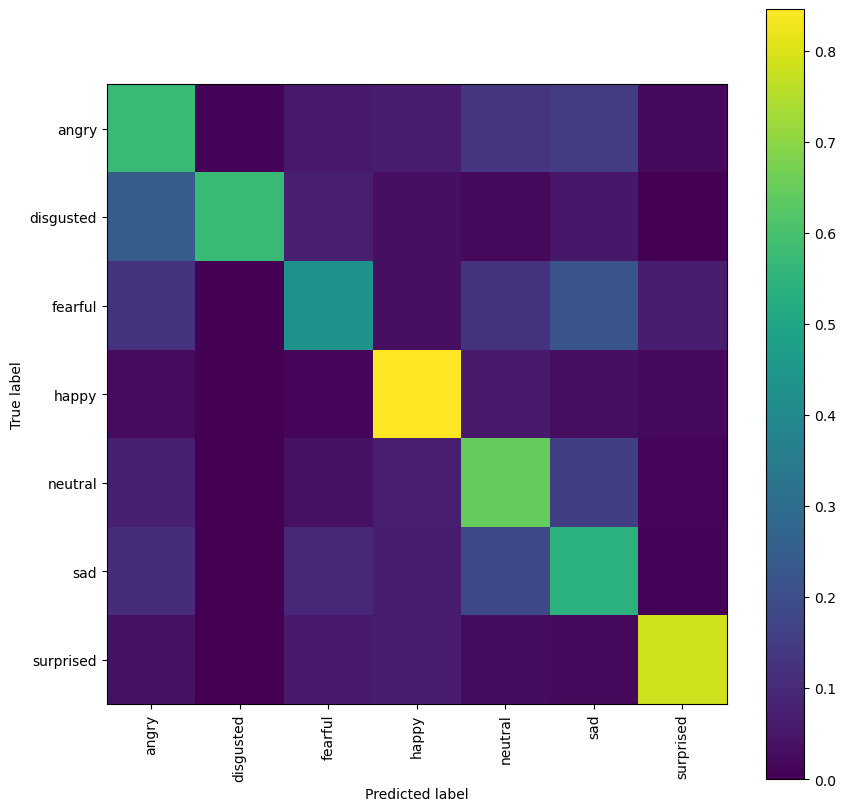

In [48]:
emotion_labels = {
    "angry": 0,
    "disgusted": 1,
    "fearful": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprised": 6
}

cm = confusion_matrix(model3_eval["test_labels"], model3_eval["test_preds"])
cm = cm.astype("float64")

# Normalize each row
for i in range(cm.shape[0]):
    cm[i, :] = cm[i, :] / sum(cm[i, :])

# Plot the confusion matrix
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(len(emotion_labels)), emotion_labels.keys(), rotation="vertical")
plt.yticks(range(len(emotion_labels)), emotion_labels.keys())
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### 5.0 Testing second dataset

#### 5.1 Preprocessing csv image file

In [21]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = 'CK_Plus.zip'

# Get the current working directory
destination_folder = os.getcwd()

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files and folders in the zip file
    for file in zip_ref.namelist():
        # Check if the file belongs to the "CK+48" folder
        if file.startswith('CK+48/'):
            # Extract only the "CK+48" folder and its contents
            zip_ref.extract(file, destination_folder)

print(f"'CK+48' folder extracted to {destination_folder}")

'CK+48' folder extracted to /home/student/SSY340-Project/Emotion classification


CKPlus has different emotion labels (no neutral, but extra emotion: contemt)

In [22]:
emotion_labels_CKP = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "sadness": 4,
    "surprise": 5,
    "contempt": 6
}

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [23]:
# Define the path to the CK+48 directory
ck_plus_dir = Path('CK+48')

# Define the list of emotion classes we're interested in
emotion_classes = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise', 'contempt']

# Function to count image files in a given directory and its subdirectories
def count_images_in_folder(directory):
    return len(list(directory.glob('**/*.*')))  # Adjust pattern to target specific file types (e.g., '*.jpg')

# Function to count images in each emotion subfolder
def count_images_in_classes(base_directory, classes):
    class_counts = {}
    for emotion in classes:
        class_dir = base_directory / emotion
        if class_dir.is_dir():
            class_counts[emotion] = count_images_in_folder(class_dir)
    return class_counts

# Count images in each class for CK+48 dataset
ck_plus_class_counts = count_images_in_classes(ck_plus_dir, emotion_classes)

# Calculate total images
total_images = sum(ck_plus_class_counts.values())

# Print results for the CK+48 set
print(f"Number of images in CK+48: {total_images}")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / total_images) * 100:.2f}%)"
                               for class_name, count in ck_plus_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

# Weights for training (used later as the dataset may not be balanced)
W_training = torch.tensor([count for class_name, count in ck_plus_class_counts.items()], dtype=torch.float32)
print(W_training)

Number of images in CK+48: 981
  Class counts: anger: 135 (13.76%) | disgust: 177 (18.04%) | fear: 75 (7.65%) | happy: 207 (21.10%) | sadness: 84 (8.56%) | surprise: 249 (25.38%) | contempt: 54 (5.50%)
tensor([135., 177.,  75., 207.,  84., 249.,  54.])


In [24]:
# Define paths to CK+48, and train/test directories
ck_plus_dir = Path('CK+48')
train_dir = Path('CKP_train')
test_dir = Path('CKP_validation')

# Define the list of emotion classes we're interested in
emotion_classes = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise', 'contempt']

# Create train and test directories if they don't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Create emotion subdirectories inside train and test directories
for emotion in emotion_classes:
    (train_dir / emotion).mkdir(parents=True, exist_ok=True)
    (test_dir / emotion).mkdir(parents=True, exist_ok=True)

# Function to split images into train and test sets and rename them
def split_and_rename_images(emotion, files, train_split=0.8):
    # Shuffle files to randomize the selection
    random.shuffle(files)
    
    # Split into train (80%) and test (20%)
    split_index = int(len(files) * train_split)
    train_files = files[:split_index]
    test_files = files[split_index:]
    
    # Move and rename files in the train set
    for file in train_files:
        new_name = f"{emotion}.{file.stem}.png"  # Rename format: emotion_type.previous_name.png
        shutil.copy(file, train_dir / emotion / new_name)  # Save to the correct emotion folder in train
    
    # Move and rename files in the test set
    for file in test_files:
        new_name = f"{emotion}.{file.stem}.png"
        shutil.copy(file, test_dir / emotion / new_name)  # Save to the correct emotion folder in test

# Process each emotion class folder
for emotion in emotion_classes:
    class_dir = ck_plus_dir / emotion
    
    if class_dir.is_dir():
        # Get all image files in the current emotion class folder
        image_files = list(class_dir.glob('*.*'))  # Adjust if necessary to target specific file types
        
        # Split and rename files into train and test sets
        split_and_rename_images(emotion, image_files)

### examine dataset structure

In [42]:
ck_plus_dir = Path('CKP_train')

# Define the list of emotion classes we're interested in
emotion_classes = ['anger', 'disgust', 'fear', 'happy','neutral', 'sadness', 'surprise', 'contempt']

# Function to count image files in a given directory and its subdirectories
def count_images_in_folder(directory):
    return len(list(directory.glob('**/*.*')))  # Adjust pattern to target specific file types (e.g., '*.jpg')

# Function to count images in each emotion subfolder
def count_images_in_classes(base_directory, classes):
    class_counts = {}
    for emotion in classes:
        class_dir = base_directory / emotion
        if class_dir.is_dir():
            class_counts[emotion] = count_images_in_folder(class_dir)
    return class_counts

# Count images in each class for CK+48 dataset
ck_plus_class_counts = count_images_in_classes(ck_plus_dir, emotion_classes)

# Calculate total images
total_images = sum(ck_plus_class_counts.values())

# Print results for the CK+48 set
print(f"Number of images in CK+48: {total_images}")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / total_images) * 100:.2f}%)"
                               for class_name, count in ck_plus_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

# Weights for training (used later as the dataset may not be balanced)
W_CKP_training = torch.tensor([count for class_name, count in ck_plus_class_counts.items()], dtype=torch.float32)
print(W_CKP_training)

Number of images in CK+48: 5902
  Class counts: anger: 130 (2.20%) | disgust: 168 (2.85%) | fear: 72 (1.22%) | happy: 198 (3.35%) | neutral: 4965 (84.12%) | sadness: 81 (1.37%) | surprise: 237 (4.02%) | contempt: 51 (0.86%)
tensor([ 130.,  168.,   72.,  198., 4965.,   81.,  237.,   51.])


In [27]:
class CKP_EmotionsData(Dataset):
    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './emotion_data'
            transform (Compose): A composition of image transforms.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform

        # Define emotion labels and their corresponding indices
        
        self.emotion_labels = {
            "anger": 0,
            "disgust": 1,
            "fear": 2,
            "happy": 3,
            "sadness": 4,
            "surprise": 5,
            "contempt": 6
        }


        # Collect samples and store pairs of (filepath, label) in a list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels for emotions

        Helper method for the constructor.
        """
        # Create an empty list to store all paths and labels
        all_paths_and_labels = []
        
        # Iterate over each emotion and its corresponding label
        for emotion, label in self.emotion_labels.items():
            
            # Collect paths for the current emotion
            emotion_paths = self._collect_imgs_sub_dir(self.root / emotion)
            
            # Map each path to the corresponding emotion label
            emotion_paths_and_labels = map(lambda path: (path, label), emotion_paths)
            
            # Add to the list of all paths and labels
            all_paths_and_labels.extend(emotion_paths_and_labels)
        
        # Sort the paths for consistency (by filename stem)
        return sorted(all_paths_and_labels, key=lambda x: x[0].stem)
            

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.png")

    
    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.

        Args:
            id_ (str): Image id, e.g. `emotion.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

In [28]:
# transform the data to tensor
transform = Compose([ToTensor()])

# create initial object for the training dataset
CKP_train_path = "./CKP_train"
CKP_train_dataset = CKP_EmotionsData(CKP_train_path, transform = transform)

CKP_validation_path = "./CKP_validation"
CKP_validation_dataset = CKP_EmotionsData(CKP_validation_path, transform = transform)


In [29]:
print(calculate_mean_std(CKP_train_dataset))
print(calculate_mean_std(CKP_validation_dataset))

(tensor([0.5121]), tensor([0.2889]))
(tensor([0.5103]), tensor([0.2890]))


In [30]:
train_mean, train_std = calculate_mean_std(CKP_train_dataset)

# New transform including normalization
transformation_w_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean,  
                         std=train_std)   
])

# Crearting normalized datasets
n_train_dataset = CKP_EmotionsData(CKP_train_path, transform = transformation_w_norm)

n_validation_dataset = CKP_EmotionsData(CKP_validation_path, transform = transformation_w_norm)


In [31]:
batch_size = 32 
workers = 8 # Works for chosen gpu

train_Dataloader = DataLoader(n_train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
validation_Dataloader = DataLoader(n_validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

#### Training using model 2

In [39]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model
image_size = 48
model = EmotionDetectionModel2(image_size).to(device)

W_CKP_training = W_CKP_training.to(device)

# Parameters
# Transform and Dataloaders defined above!
print_every = None
num_epochs = 100
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = W_CKP_training)

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_Dataloader, validation_Dataloader, num_epochs, print_every)

Using device: cuda
Starting training
Epoch 1/100: Train loss: 1.040, Train acc.: 0.551, Val. loss: 0.428, Val. acc.: 0.744
Epoch 2/100: Train loss: 0.457, Train acc.: 0.769, Val. loss: 0.291, Val. acc.: 0.852
Epoch 3/100: Train loss: 0.300, Train acc.: 0.832, Val. loss: 0.165, Val. acc.: 0.935


KeyboardInterrupt: 

In [61]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
    },
    "./CK_model_2.ckpt",
)

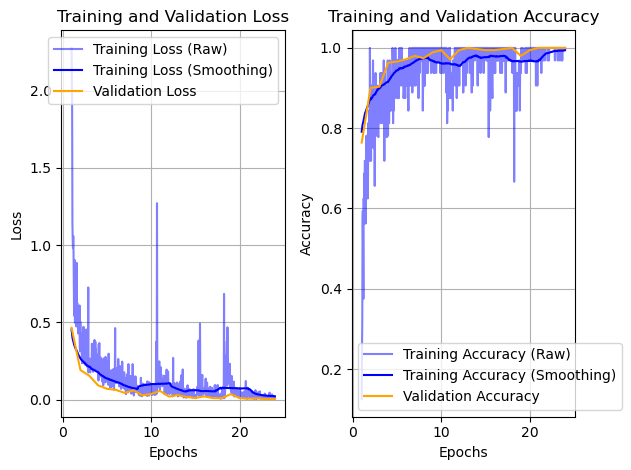

In [38]:
train_val_plots(train_losses, train_accs, val_losses, val_accs)

#### Training using model 3

In [66]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model
image_size = 48
model = EmotionDetectionModel3(image_size).to(device)

# Parameters
# Transform and Dataloaders defined above!
print_every = None
num_epochs = 100
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = W_training)

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_Dataloader, validation_Dataloader, num_epochs, print_every)

Using device: cuda
Starting training
Epoch 1/100: Train loss: 0.873, Train acc.: 0.608, Val. loss: 0.401, Val. acc.: 0.729
Epoch 2/100: Train loss: 0.405, Train acc.: 0.774, Val. loss: 0.237, Val. acc.: 0.827
Epoch 3/100: Train loss: 0.277, Train acc.: 0.856, Val. loss: 0.173, Val. acc.: 0.942
Epoch 4/100: Train loss: 0.198, Train acc.: 0.910, Val. loss: 0.102, Val. acc.: 0.960
Epoch 5/100: Train loss: 0.163, Train acc.: 0.924, Val. loss: 0.105, Val. acc.: 0.982
Epoch 6/100: Train loss: 0.138, Train acc.: 0.935, Val. loss: 0.071, Val. acc.: 0.982
Epoch 7/100: Train loss: 0.133, Train acc.: 0.947, Val. loss: 0.099, Val. acc.: 0.964
Epoch 8/100: Train loss: 0.102, Train acc.: 0.961, Val. loss: 0.053, Val. acc.: 0.973
Epoch 9/100: Train loss: 0.087, Train acc.: 0.971, Val. loss: 0.035, Val. acc.: 1.000
Epoch 10/100: Train loss: 0.081, Train acc.: 0.968, Val. loss: 0.026, Val. acc.: 1.000
Epoch 11/100: Train loss: 0.062, Train acc.: 0.980, Val. loss: 0.020, Val. acc.: 1.000
Epoch 12/100: T

In [68]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
    },
    "./CK_model_3.ckpt",
)

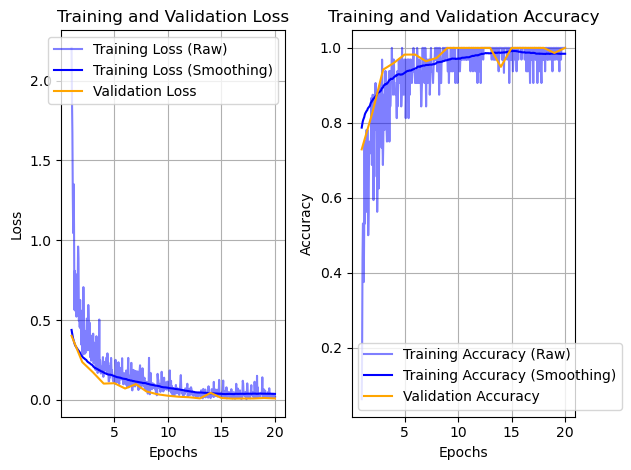

In [67]:
train_val_plots(train_losses, train_accs, val_losses, val_accs)

### 6.0 Second dataset expanded with neutral

### Add neutral from Fer2013 to CK+

In [40]:
# Define the paths for source and destination directories
train_neutral_src = Path('train/neutral')
validation_neutral_src = Path('validation/neutral')

# Define the destination paths
ckp_train_dir = Path('CKP_train/neutral')
ckp_validation_dir = Path('CKP_validation/neutral')

# Create destination directories if they don't exist
ckp_train_dir.mkdir(parents=True, exist_ok=True)
ckp_validation_dir.mkdir(parents=True, exist_ok=True)

# Copy the 'neutral' folder from train to CKP_train
if train_neutral_src.exists():
    shutil.copytree(str(train_neutral_src), str(ckp_train_dir), dirs_exist_ok=True)
    print(f"Copied {train_neutral_src} to {ckp_train_dir}")

# Copy the 'neutral' folder from validation to CKP_validation
if validation_neutral_src.exists():
    shutil.copytree(str(validation_neutral_src), str(ckp_validation_dir), dirs_exist_ok=True)
    print(f"Copied {validation_neutral_src} to {ckp_validation_dir}")

Copied train/neutral to CKP_train/neutral
Copied validation/neutral to CKP_validation/neutral


In [41]:
emotion_labels_CKPE = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6,
    "contempt": 7
}

#### Examine dataset structure

In [51]:
ck_plus_dir = Path('CKP_train')

# Define the list of emotion classes we're interested in
emotion_classes = ['anger', 'disgust', 'fear', 'happy','neutral', 'sadness', 'surprise', 'contempt']

# Function to count image files in a given directory and its subdirectories
def count_images_in_folder(directory):
    return len(list(directory.glob('**/*.*')))  # Adjust pattern to target specific file types (e.g., '*.jpg')

# Function to count images in each emotion subfolder
def count_images_in_classes(base_directory, classes):
    class_counts = {}
    for emotion in classes:
        class_dir = base_directory / emotion
        if class_dir.is_dir():
            class_counts[emotion] = count_images_in_folder(class_dir)
    return class_counts

# Count images in each class for CK+48 dataset
ck_plus_class_counts = count_images_in_classes(ck_plus_dir, emotion_classes)

# Calculate total images
total_images = sum(ck_plus_class_counts.values())

# Print results for the CK+48 set
print(f"Number of images in CK+48: {total_images}")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / total_images) * 100:.2f}%)"
                               for class_name, count in ck_plus_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

# Weights for training (used later as the dataset may not be balanced)
W_CKPE_training = torch.tensor([count for class_name, count in ck_plus_class_counts.items()], dtype=torch.float32)
print(W_CKPE_training)

Number of images in CK+48: 5902
  Class counts: anger: 130 (2.20%) | disgust: 168 (2.85%) | fear: 72 (1.22%) | happy: 198 (3.35%) | neutral: 4965 (84.12%) | sadness: 81 (1.37%) | surprise: 237 (4.02%) | contempt: 51 (0.86%)
tensor([ 130.,  168.,   72.,  198., 4965.,   81.,  237.,   51.])


In [44]:
class CKPE_EmotionsData(Dataset):
    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './emotion_data'
            transform (Compose): A composition of image transforms.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform

        # Define emotion labels and their corresponding indices
        

        self.emotion_labels = {
            "anger": 0,
            "disgust": 1,
            "fear": 2,
            "happy": 3,
            "neutral": 4,
            "sadness": 5,
            "surprise": 6,
            "contempt": 7
        }


        # Collect samples and store pairs of (filepath, label) in a list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels for emotions

        Helper method for the constructor.
        """
        # Create an empty list to store all paths and labels
        all_paths_and_labels = []
        
        # Iterate over each emotion and its corresponding label
        for emotion, label in self.emotion_labels.items():
            
            # Collect paths for the current emotion
            emotion_paths = self._collect_imgs_sub_dir(self.root / emotion)
            
            # Map each path to the corresponding emotion label
            emotion_paths_and_labels = map(lambda path: (path, label), emotion_paths)
            
            # Add to the list of all paths and labels
            all_paths_and_labels.extend(emotion_paths_and_labels)
        
        # Sort the paths for consistency (by filename stem)
        return sorted(all_paths_and_labels, key=lambda x: x[0].stem)
            

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.png")

    
    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.

        Args:
            id_ (str): Image id, e.g. `emotion.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

### Normalize input

In [45]:
# transform the data to tensor
transform = Compose([ToTensor()])

# create initial object for the training dataset
CKP_train_path = "./CKP_train"
CKPE_train_dataset = CKP_EmotionsData(CKP_train_path, transform = transform)

CKP_validation_path = "./CKP_validation"
CKPE_validation_dataset = CKP_EmotionsData(CKP_validation_path, transform = transform)

In [47]:
print(calculate_mean_std(CKPE_train_dataset))
print(calculate_mean_std(CKPE_validation_dataset))

(tensor([0.5121]), tensor([0.2889]))
(tensor([0.5103]), tensor([0.2890]))


In [48]:
train_mean, train_std = calculate_mean_std(CKPE_train_dataset)

# New transform including normalization
transformation_w_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean,  
                         std=train_std)   
])

# Crearting normalized datasets
CKPE_train_dataset = CKPE_EmotionsData(CKP_train_path, transform = transformation_w_norm)

CKPE_validation_dataset = CKPE_EmotionsData(CKP_validation_path, transform = transformation_w_norm)

In [49]:
batch_size = 32 
workers = 8 # Works for chosen gpu

CKPE_train_Dataloader = DataLoader(CKPE_train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
CKPE_validation_Dataloader = DataLoader(CKPE_validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

### Model with extended classification outputs

In [53]:
batch_size = 32 # choose high for fast training, in my experience

#train_Dataloader = DataLoader(n_train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
#validation_Dataloader = DataLoader(n_validation_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
#test_Dataloader = DataLoader(n_test_dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

class EmotionDetectionModel3CKPE(nn.Module):
    
    def __init__(self, img_size):
        super(EmotionDetectionModel3CKPE, self).__init__()

        self._num_classes = 8
        self._img_channels = 1
        self.dropout_factor1 = 0.2
        self.dropout_factor2 = 0.4

        # input to BatchNorm2d is the amount of filters
        
        # First convolution block -----
        self.conv1 = nn.Conv2d(in_channels=self._img_channels, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        
        
        # Second convolution block -----
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.4)
        
        
        # Third convolution block -----
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        #self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.4)


        # fourth convolution block -----
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        
        #self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.4)


        # Fully connected layers
        
        # Calculate the output size of the feature maps after the convolutional layers
        self.flatten_size = self._calculate_conv_output_size(img_size)

        # Fully connected layer 1
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn9 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.6)

        # Fully connected layer 2
        self.fc2 = nn.Linear(128, self._num_classes)

    
    def _calculate_conv_output_size(self, img_size):
        # Helper method to compute the spatial dimensions after the convolution and pooling layers
        size = img_size // 4  # Since 3 pooling layers, we reduce the size by a factor of 8
        return size * size * 256  # 256 filters at the final conv layer

    
    def save_model(self, train_losses, train_accs, val_losses, val_accs):
        # Get the current date and time
        date_and_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

        # Save the model state and training history
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "train_losses": train_losses,
                "train_accs": train_accs,
                "val_losses": val_losses,
                "val_accs": val_accs,
            },
            f"./EmotionDetectionModel-{date_and_time}.ckpt",  # Use f-string for formatting
        )
        
    
    def forward(self, x):
        
        # First convolution block -----
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second convolution block -----
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third convolution block (no pooling) -----
        x = F.elu(self.bn5(self.conv5(x)))
        x = F.elu(self.bn6(self.conv6(x)))
        x = self.dropout3(x)
    
        # Fourth convolution block (no pooling) -----
        x = F.elu(self.bn7(self.conv7(x)))
        x = F.elu(self.bn8(self.conv8(x)))
        x = self.dropout4(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.bn9(self.fc1(x)))
        x = self.dropout5(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x

### Training 

In [55]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model
image_size = 48
model = EmotionDetectionModel3CKPE(image_size).to(device)

W_CKPE_training = W_CKPE_training.to(device)

# Parameters
# Transform and Dataloaders defined above!
print_every = None
num_epochs = 100
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = W_CKPE_training)

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, CKPE_train_Dataloader, CKPE_validation_Dataloader, num_epochs, print_every)

Using device: cuda
Starting training
Epoch 1/100: Train loss: 0.649, Train acc.: 0.768, Val. loss: 0.090, Val. acc.: 0.703
Epoch 2/100: Train loss: 0.099, Train acc.: 0.851, Val. loss: 0.058, Val. acc.: 0.722
Epoch 3/100: Train loss: 0.056, Train acc.: 0.861, Val. loss: 0.088, Val. acc.: 0.639
Epoch 4/100: Train loss: 0.046, Train acc.: 0.859, Val. loss: 0.055, Val. acc.: 0.747
Epoch 5/100: Train loss: 0.038, Train acc.: 0.867, Val. loss: 0.082, Val. acc.: 0.670
Epoch 6/100: Train loss: 0.034, Train acc.: 0.875, Val. loss: 0.050, Val. acc.: 0.737
Epoch 7/100: Train loss: 0.034, Train acc.: 0.873, Val. loss: 0.063, Val. acc.: 0.732
Epoch 8/100: Train loss: 0.025, Train acc.: 0.885, Val. loss: 0.045, Val. acc.: 0.779
Epoch 9/100: Train loss: 0.028, Train acc.: 0.880, Val. loss: 0.056, Val. acc.: 0.732
Epoch 10/100: Train loss: 0.027, Train acc.: 0.885, Val. loss: 0.042, Val. acc.: 0.784
Epoch 11/100: Train loss: 0.023, Train acc.: 0.893, Val. loss: 0.039, Val. acc.: 0.785
Epoch 12/100: T

In [56]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
    },
    "./CKPE_model_3.ckpt",
)

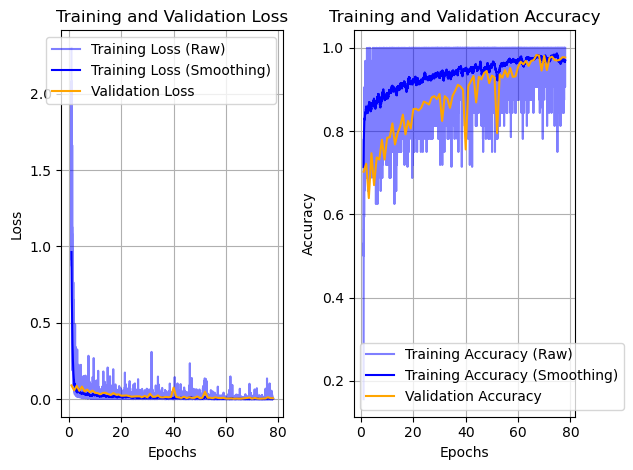

In [57]:
train_val_plots(train_losses, train_accs, val_losses, val_accs)

### Performance metrics

The function below is like to previous evaluate_model_on_datasets() but it does not have a test_loader as input or test performance as output

In [58]:
def evaluate_model_on_datasets2(model, train_loader, val_loader, device):
    model.to(device)  # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    def evaluate(dataloader, name):
        correct = 0
        total = 0
        total_loss = 0.0
        all_preds = []  # List to store predictions
        all_labels = []  # List to store true labels

        with torch.no_grad():  # Disable gradient calculation for evaluation
            for data in dataloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()

                # Get predictions
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())  # Store predictions
                all_labels.extend(labels.cpu().numpy())    # Store true labels

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(dataloader)
        print(f"{name} - Accuracy: {accuracy:.2f}%, Average Loss: {avg_loss:.4f}")

        return all_preds, all_labels  # Return predictions and true labels

    # Evaluate on training and validation datasets
    print("Evaluating model on datasets:")
    train_preds, train_labels = evaluate(train_loader, "Train")
    val_preds, val_labels = evaluate(val_loader, "Validation")

    return {
        "train_preds": train_preds,
        "train_labels": train_labels,
        "val_preds": val_preds,
        "val_labels": val_labels
    }

In [59]:
model3CKPE_eval =evaluate_model_on_datasets2(model, CKPE_train_Dataloader, CKPE_validation_Dataloader, device)

Evaluating model on datasets:
Train - Accuracy: 99.02%, Average Loss: 0.0303
Validation - Accuracy: 97.62%, Average Loss: 0.0861


### Confusion matrix

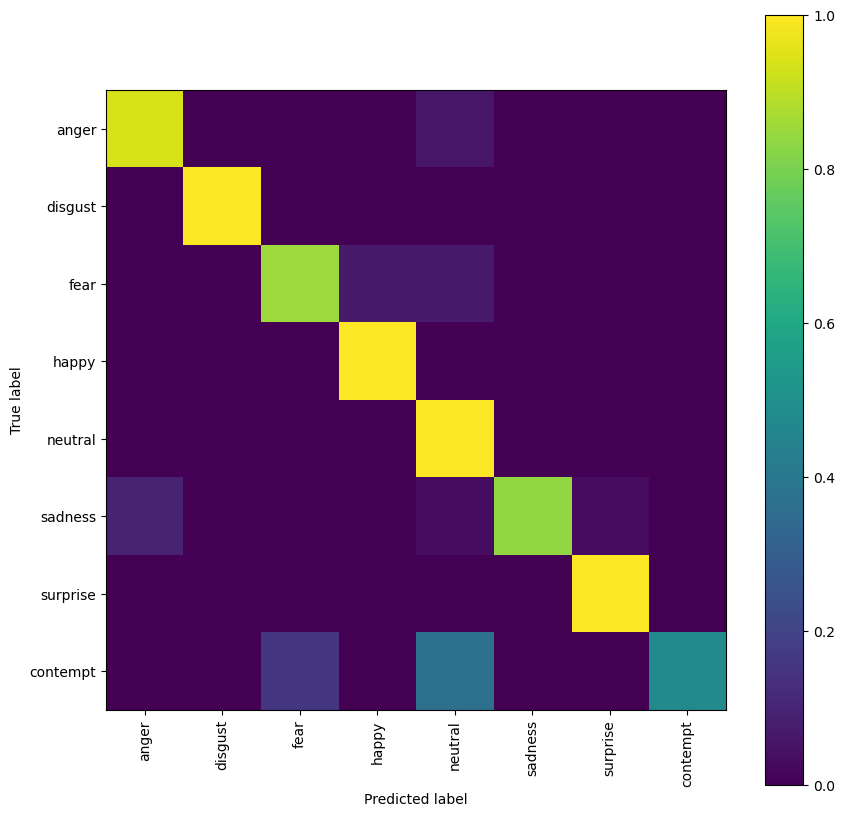

In [60]:
emotion_labels_CKPE = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6,
    "contempt": 7
}

cm = confusion_matrix(model3CKPE_eval["val_labels"], model3CKPE_eval["val_preds"])
cm = cm.astype("float64")

# Normalize each row
for i in range(cm.shape[0]):
    cm[i, :] = cm[i, :] / sum(cm[i, :])

# Plot the confusion matrix
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(len(emotion_labels_CKPE)), emotion_labels_CKPE.keys(), rotation="vertical")
plt.yticks(range(len(emotion_labels_CKPE)), emotion_labels_CKPE.keys())
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()